In [1]:
import pandas as pd
import networkx as nx
import numpy as np
import pickle as pk
import matplotlib.pyplot as plt 
from collections import Counter
from scipy import stats
import gseapy as gp
from community import community_louvain


In [4]:


def read_gene_annotation(file_path):
    """
    Reads a gene annotation file and stores it as a dictionary.
    
    Parameters:
        file_path (str): Path to the input text file.
        
    Returns:
        dict: Dictionary where keys are annotations and values are lists of genes.
    """
    gene_dict = {}
    
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split('\t')  # Split by tab
            if len(parts) > 1:
                annotation = parts[0].strip()
                genes = [gene.strip() for gene in parts[1:] if gene.strip()]
                gene_dict[annotation] = genes
    
    return gene_dict

def overlap_jaccard(list1,list2):
    intersction_term= len(set(list1) & set(list2))
    denominator = len(set(list1).union(set(list2)))
    overlap_jaccard_coeff = intersction_term/denominator
    return overlap_jaccard_coeff

def overlap_genelists(lstA, lstB, background):
    import scipy.stats as stats
    """
    Accepts to lists
    M is the population size (previously N)
    n is the number of successes in the population
    N is the sample size (previously n)
    x is still the number of drawn “successes”
    """
    setA= set(lstA)
    setB= set(lstB)
    M= background #total number of genes
    n= len(setA)
    N= len(setB)
    x= len(setA.intersection(setB))


    return str(stats.hypergeom.sf(x-1, M, n, N))



#Here we define the adjustment
from statsmodels.sandbox.stats.multicomp import multipletests
def fdr_adjustment(list_of_pvals,alpha):    
    return multipletests(list_of_pvals,alpha=alpha,method='fdr_bh')[1] #the benjamin hochberg method is used


def enrichment_fishers(foreground_list,background_lenght):
    ann_list = []
    pval_list = []
    ji_list = []
    for ann,annotation_list in tot_gene_annotation_dict.items():
        pval_ov = float(overlap_genelists(foreground_list,annotation_list,background_lenght)) 
        ji_overlap = overlap_jaccard(foreground_list,annotation_list)
        ann_list.append(ann)
        pval_list.append(pval_ov)
        ji_list.append(ji_overlap)
    adj_pval = fdr_adjustment(pval_list,0.05)
    results_df = pd.DataFrame()
    results_df['Term'] = ann_list
    results_df['Overlap'] = ji_list
    results_df['P-value'] = pval_list
    results_df['FDR'] = adj_pval
    # Sort results by adjusted p-value
    results_df = results_df.sort_values(by='FDR')
    # Compute combined score (-log10 Adjusted P-value * Overlap)
    results_df['Combined Score'] = -np.log10(results_df['FDR']) * results_df['Overlap']
    results_df_sig = results_df[results_df['FDR']<0.05]
    return results_df_sig
    
library_list = ["GO_Molecular_Function_2025","GO_Biological_Process_2025","GO_Cellular_Component_2025","Reactome_Pathways_2024"]
def enr_ranking_leading_genes(pre_rank_df,library_list):   #This function returns the leading genes
    leading_genes_tot=[]
    for lib in library_list:
        c=0
        while c<10:
            try:
                lib_pre_res = gp.prerank(rnk=pre_rank_df, gene_sets=lib,
                                 processes=4,min_size=3,max_size=5000,outdir=None,   #we impose at least 5 enriched common genes
                                 permutation_num=500) # reduce number to speed up testing
                leading_gene_lib_list=[]
                for gene_str in lib_pre_res.res2d['Lead_genes'].tolist():    #lib_pre_res.res2d['Lead_genes'] if in the cluster
                    leading_gene_lib_list.extend(gene_str.split(";"))
                leading_genes_tot.extend(leading_gene_lib_list)
                if 'Lead_genes' in lib_pre_res.res2d:
                    break
            except (NameError, AttributeError):
                c += 1
    return set(leading_genes_tot)

def read_json_to_dict(file):
    import json
    import pandas as pd
    
    # Load the JSON file (replace with your path)
    with open(file, "r") as f:
        possible_dict = json.load(f)
    
    # Initialize an empty dictionary to store DataFrames for each key
    dataframes_dict = {}
    
    # Loop through each key in the possible_dict
    for key, result in possible_dict.items():
        # Initialize an empty list to store the rows for this DataFrame
        data = []
        
        # Iterate through the list of results for each key
        for entry in result:
            # Split FgRatio and BgRatio
            fg_ratio_split = entry['FgRatio'].split('/')
            bg_ratio_split = entry['BgRatio'].split('/')
            
            # Convert the split ratios to numeric values
            fg_ratio = float(fg_ratio_split[0]) / float(fg_ratio_split[1])
            bg_ratio = float(bg_ratio_split[0]) / float(bg_ratio_split[1])
            
            # Prepare the row data with all required columns
            row = {
                'Description': entry['Description'],
                'FgRatio': fg_ratio,
                'BgRatio': bg_ratio,
                'ES': entry['ES'],
                'pvalue': entry['pvalue'],
                'FDR': entry['FDR'],
                '_row': entry['_row']
            }
            
            # Append the row to the data list
            data.append(row)
        
        # Convert the data list into a DataFrame
        df = pd.DataFrame(data)
        
        # Store the DataFrame in the dictionary with the key as its name
        dataframes_dict[key] = df
    return dataframes_dict

from community import community_louvain

#Here, we find the resolution parameter that optimizes Newman's modularity
def optimal_resolution_with_diagnostics_simple_network(G, resolution_list,weight,rd_state):
    max_modularity = -1
    modularity_scores = []
    for resolution in resolution_list:
        partition = community_louvain.best_partition(G, resolution=resolution,weight=weight,random_state=rd_state)
        modularity = community_louvain.modularity(partition,G)
        if modularity > max_modularity:   # save the partition and resolution giving the maximum modularity
            max_modularity = modularity
            best_partition = partition
            best_resolution = resolution
        modularity_scores.append((resolution, modularity))
    return best_partition, best_resolution, max_modularity, modularity_scores



In [2]:
with open('output/EEN_characteristics_dict.pickle', 'rb') as handle:
    EEN_characteristics_dict = pk.load(handle)   

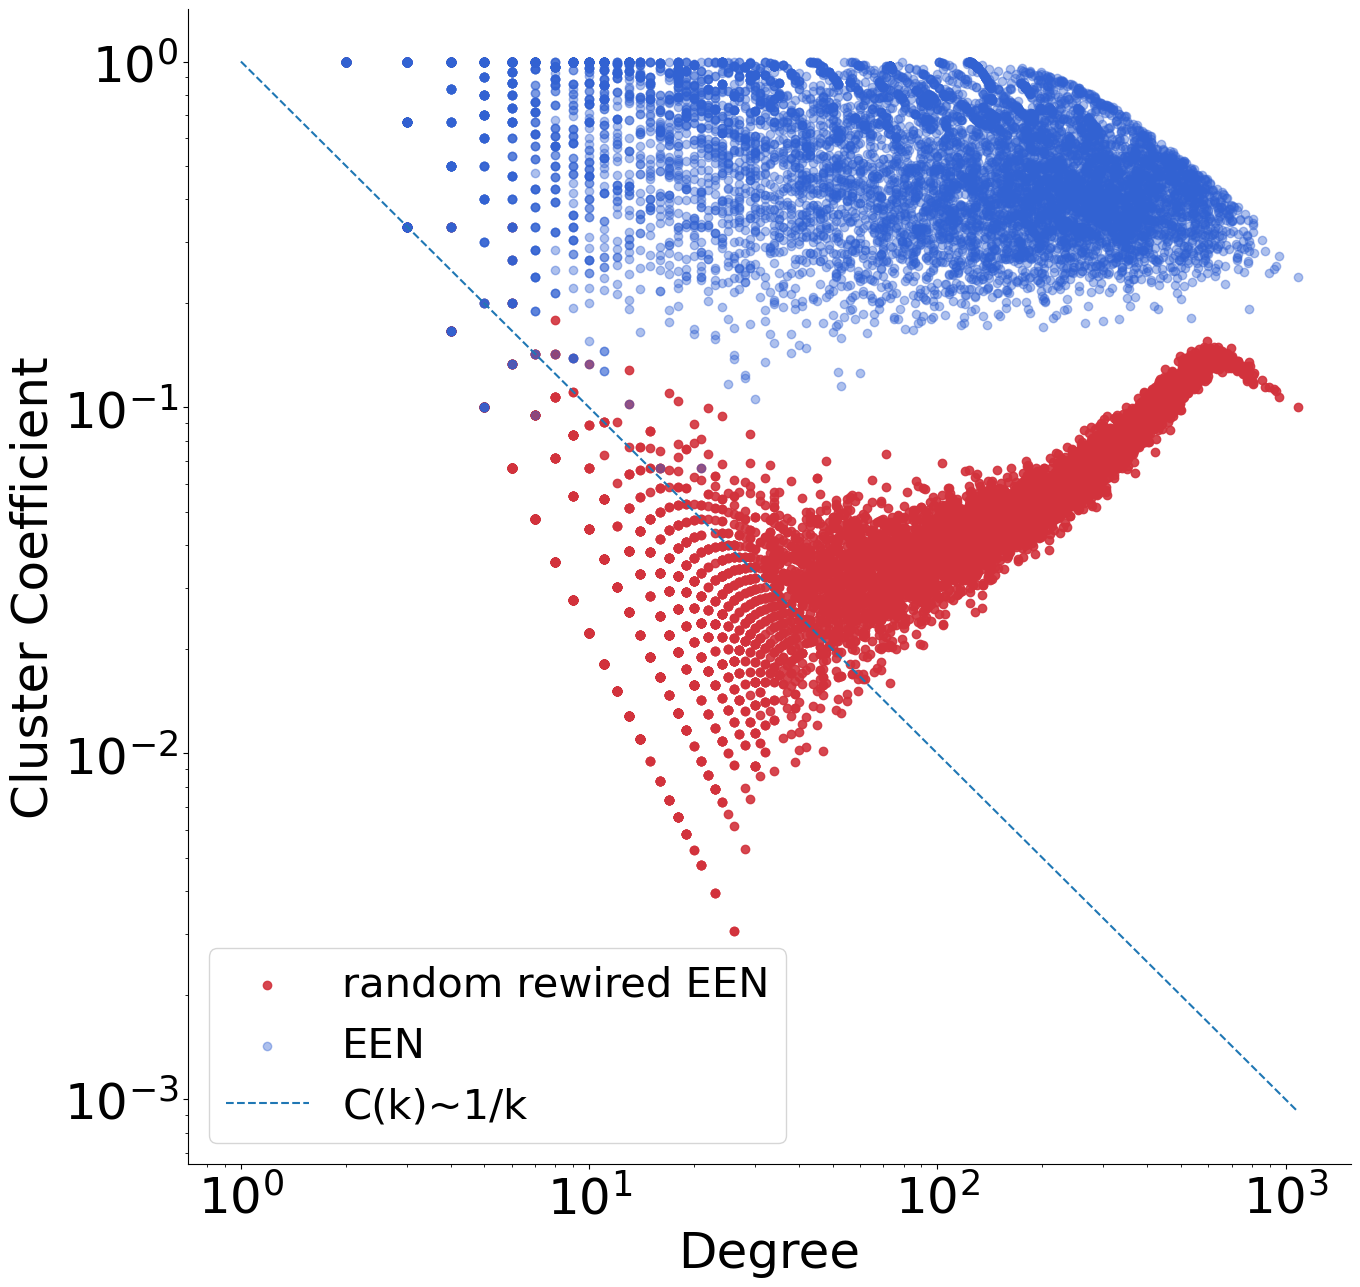

In [3]:
import matplotlib
fig, ax1 = plt.subplots(figsize=(15,15))


plt.scatter(EEN_characteristics_dict["EEN_degree"], EEN_characteristics_dict["random_EEN_clustering_coefficient"], c='#D2323C', alpha=0.9,label="random rewired EEN")
plt.scatter(EEN_characteristics_dict["EEN_degree"], EEN_characteristics_dict["EEN_clustering_coefficient"], c='#3262D2', alpha=0.4,label="EEN")
plt.plot(EEN_characteristics_dict["EEN_degree"], EEN_characteristics_dict["predicted_EEN_clustering_coefficient"], linestyle='dashed',label='C(k)~1/k')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Degree', fontsize=36)
plt.ylabel('Cluster Coefficient', fontsize=36)
#ax1.set_xticks([1,10, 100, 1000,20000])
#ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.xticks(fontsize=12, rotation=0)
plt.yticks(fontsize=12, rotation=0)

#plt.xlim(0,5000)
#plt.title('Exposures assocciated with genes')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)
plt.legend(fontsize=30)
plt.xticks(fontsize=36) 
plt.yticks(fontsize=36) 
#plt.savefig('Figures/AddFig_HierarchicalCom.pdf',format='pdf',dpi=300, bbox_inches = "tight")
plt.show()
plt.close()

In [4]:
source_df = pd.DataFrame({
    "random_EEN_clustering_coefficient": EEN_characteristics_dict["random_EEN_clustering_coefficient"],
    "EEN_degree": EEN_characteristics_dict["EEN_degree"],
    "EEN_clustering_coefficient": EEN_characteristics_dict["EEN_clustering_coefficient"],
    "predicted_EEN_clustering_coefficient": EEN_characteristics_dict["predicted_EEN_clustering_coefficient"]
})


excel_path = "output/Source_Data_exposurome.xlsx"

with pd.ExcelWriter(
        excel_path,
        engine="openpyxl",
        mode="a",
        if_sheet_exists="replace"
    ) as writer:

    source_df.to_excel(
        writer,
        sheet_name="SF12A",
        index=False
    )

print("Scatter source data saved.")

Scatter source data saved.


In [5]:
#Let's import the randomized EEN
random_een_df = pd.read_csv("output/random_een.tsv", sep="\t",index_col=0)
random_een = nx.from_pandas_edgelist(random_een_df, 'Exp A', 'Exp B')

een = nx.read_weighted_edgelist("output/backbone_exp_graph_significant_weighted.edgelist")

In [20]:
random_een_density = nx.density(random_een)
een_density = nx.density(een)

In [6]:
def optimal_resolution(G, resolution_list,weight,random_state):
    """
    Param:
    G: A networkx graph
    resolution_list: List of resolution values to check
    """
    res_mod_dict = {}
    max_modularity = -1 # initialize maximum modularity as negative value
    for resolution in resolution_list:
        partition = community_louvain.best_partition(G, resolution=resolution,weight=weight,random_state=random_state)
        modularity = community_louvain.modularity(partition,G)
        res_mod_dict[resolution] = modularity

        if modularity > max_modularity:   # save the partition and resolution giving the maximum modularity
            max_modularity = modularity
            best_partition = partition
            best_resolution = resolution
            
    return best_partition, best_resolution, max_modularity,res_mod_dict

In [7]:
def overlap_jaccard(list1,list2):
    intersction_term= len(set(list1) & set(list2))
    denominator = len(set(list1).union(set(list2)))
    overlap_jaccard_coeff = intersction_term/denominator
    return overlap_jaccard_coeff

In [8]:

#Let's import the chemical-gene interactions from CTD (downloaded on 5th April 2021)
chem_gene_df = pd.read_csv("input/CTD/CTD_chem_gene_ixns.tsv",delimiter= '\t', skipinitialspace=True)
#Here, we filter for only the interactions that regards the H. Sapiens
chem_homo = chem_gene_df[(chem_gene_df['Organism'] == 'Homo sapiens')]

#Let's import the network
backbone_ss_exposure_network = nx.read_weighted_edgelist("output/backbone_exp_graph_significant_weighted.edgelist")

#This cells create a dictionary where each key is a chemical compound and the correspondent value is a genelist
chem_gene = {}
for i,v in chem_homo.iterrows():
    try:
        chem_gene[v["ChemicalID"]] |= {v["GeneSymbol"]}
    except KeyError as e:
        chem_gene[v["ChemicalID"]] = set([v["GeneSymbol"]])

#Here, we keep only the exposures which perturb at least one gene
chem_gene_cleaned = {}
tot_gene_list=[]
for k,v in chem_gene.items():
    if len(v)>0:
        chem_gene_cleaned[k]=v
        for gene in v:
            tot_gene_list.append(gene)
    else:
        pass


In [9]:


random_een_weighted = nx.Graph()
for e in random_een.edges():
    ji= overlap_jaccard(chem_gene_cleaned[e[0]],chem_gene_cleaned[e[1]])  
    random_een_weighted.add_edge(*e)
    random_een_weighted[e[0]][e[1]]['weight']=ji
    

In [11]:
resolution_list = np.linspace(0.1, 2, 20) 


een_best_partition, een_best_resolution, een_max_modularity, een_modularity_scores = optimal_resolution(een, resolution_list,'weight',5495)
random_een_best_partition, random_een_best_resolution, random_een_max_modularity, random_een_modularity_scores = optimal_resolution(random_een_weighted, resolution_list,'weight',5495)



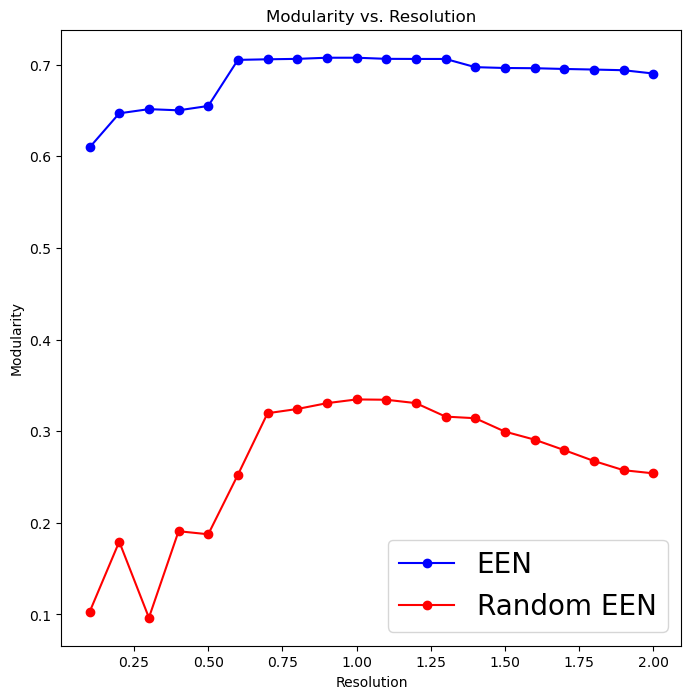

In [20]:
#This plot shows the relationship between resolution and modularity
plt.figure(figsize=(8, 8))
# Plot the modularity versus resolution

plt.plot(resolution_list, [v for v in een_modularity_scores.values()], marker='o',color="blue",label='EEN')
plt.plot(resolution_list, [v for v in random_een_modularity_scores.values()], marker='o',color="red",label='Random EEN')

plt.xlabel('Resolution')
plt.ylabel('Modularity')
plt.title('Modularity vs. Resolution')
plt.legend(fontsize=20)
plt.savefig('output/Figures/SF6B_v02_post_rev.pdf',format='pdf',dpi=300, bbox_inches = "tight")
plt.show()



In [19]:

rows = []

def add_curve(condition, resolutions, modularities, color):
    for r, m in zip(resolutions, modularities):
        rows.append({
            "Condition": condition,
            "Resolution": r,
            "Modularity": m,
            "Color": color,
            "Marker": "o"
        })

add_curve("EEN",
          een_modularity_scores.keys(),
          een_modularity_scores.values(),
          "blue")

add_curve("Random EEN",
          random_een_modularity_scores.keys(),
          random_een_modularity_scores.values(),
          "red")

modularity_source_df = pd.DataFrame(rows)

excel_path = "output/Source_Data_exposurome.xlsx"

with pd.ExcelWriter(
        excel_path,
        engine="openpyxl",
        mode="a",
        if_sheet_exists="replace"
    ) as writer:

    modularity_source_df.to_excel(
        writer,
        sheet_name="SF12B",
        index=False
    )

print("Source data saved for modularity vs resolution plot.")

Source data saved for modularity vs resolution plot.


In [14]:
resolution_list = np.linspace(0.1, 2, 20) 

best_partition, best_resolution, max_modularity, res_mod_dict = optimal_resolution(random_een_weighted, resolution_list,'weight',5495)
print('Optimal resolution value: ', best_resolution)

Optimal resolution value:  0.9999999999999999


In [15]:
#Here, we calculate the communities in hierarchical fashion with Louvain
#We take into account the weights of the weighted network and the best resolution parameter

dendo = community_louvain.generate_dendrogram(random_een_weighted,resolution=1 ,weight='weight',random_state=5495)

In [16]:
#There are three hierarchical levels
len(dendo)

3

In [17]:
#Let's define the three hierarchical communities as dictionaries
ee_first_louvain_iteration_exposures={}   

for com in set(list(dendo[0].values())):
    exp_list=[]
    for exp, comcom in dendo[0].items():
        if com==comcom:
            exp_list.append(exp)
    ee_first_louvain_iteration_exposures[com]=exp_list
    
ee_first_louvain_iteration={}  #this dictionary contains the middle-hierarchical level as keys and the respective (dividing)
                               #finest (first) hierarchical communities as values
for com in set(list(dendo[1].values())):
    exp_list=[]
    for exp, comcom in dendo[1].items():
        if com==comcom:
            exp_list.append(exp)
    ee_first_louvain_iteration[com]=exp_list
    
ee_second_louvain_iteration={} #this dictionary has the broad-hierarchical (third) level as keys and the respective (dividing)
                               #middle (second) hierarchical communities as values
for com in set(list(dendo[2].values())):
    exp_list=[]
    for exp, comcom in dendo[2].items():
        if com==comcom:
            exp_list.append(exp)
    ee_second_louvain_iteration[com]=exp_list
    
#These communities are the middle and the broad level related to each community

ee_second_louvain_iteration_exposures={}  
for com, com_list in ee_first_louvain_iteration.items():
    exp_list=[]
    for comcom in com_list:
        exp_list.extend(ee_first_louvain_iteration_exposures[comcom])
    ee_second_louvain_iteration_exposures[com]=exp_list

ee_third_louvain_iteration_exposures={}
for com, com_list in ee_second_louvain_iteration.items():
    exp_list=[]
    for comcom in com_list:
        exp_list.extend(ee_second_louvain_iteration_exposures[comcom])
    ee_third_louvain_iteration_exposures[com]=exp_list

In [18]:
#Let's change the nomenclature of these communities

#BROADEST==third
third_level_louvain_sort=dict(sorted(ee_third_louvain_iteration_exposures.items(), key=lambda item: len(item[1]), reverse = True))
third_renamed_third_conversion_dict={}
renamed_third_level_louvain_sort={}
c=1
for com,explist in third_level_louvain_sort.items():
    renamed_third_level_louvain_sort[str(c)]=explist
    third_renamed_third_conversion_dict[com]=str(c)
    c=c+1
    
#MIDDLE==second

second_renamed_second_conversion_dict={}
renamed_second_level_louvain_sort={}

for br_com,mid_com in ee_second_louvain_iteration.items():
    if len(mid_com)==1:
        newcom=third_renamed_third_conversion_dict[br_com]
        renamed_second_level_louvain_sort[newcom]=ee_second_louvain_iteration_exposures[mid_com[0]]
        second_renamed_second_conversion_dict[mid_com[0]]=newcom
    else:
        sorted_list=list(sorted(mid_com, key=lambda item: len(ee_second_louvain_iteration_exposures[item]), reverse = True))
        for i in range(len(sorted_list)):
            q=i+1
            newcom=third_renamed_third_conversion_dict[br_com]+"_"+str(q)
            renamed_second_level_louvain_sort[newcom]=ee_second_louvain_iteration_exposures[sorted_list[i]]
            second_renamed_second_conversion_dict[sorted_list[i]]=newcom
        
#FINEST==first  

first_renamed_first_conversion_dict={}
renamed_first_level_louvain_sort={}

for mid_com,fin_com in ee_first_louvain_iteration.items():
    if len(fin_com)==1:
        newcom=second_renamed_second_conversion_dict[mid_com]
        renamed_first_level_louvain_sort[newcom]=ee_first_louvain_iteration_exposures[fin_com[0]]
        first_renamed_first_conversion_dict[fin_com[0]]=newcom
    else:
        sorted_list=list(sorted(fin_com, key=lambda item: len(ee_first_louvain_iteration_exposures[item]), reverse = True))
        for i in range(len(sorted_list)):
            q=i+1
            newcom=second_renamed_second_conversion_dict[mid_com]+"_"+str(q)
            renamed_first_level_louvain_sort[newcom]=ee_first_louvain_iteration_exposures[sorted_list[i]]
            first_renamed_first_conversion_dict[sorted_list[i]]=newcom
        
third_renamed_third_conversion_dict_rev={}
for k,v in third_renamed_third_conversion_dict.items():
    third_renamed_third_conversion_dict_rev[v]=k

second_renamed_second_conversion_dict_rev={}
for k,v in second_renamed_second_conversion_dict.items():
    second_renamed_second_conversion_dict_rev[v]=k

first_renamed_first_conversion_dict_rev={}
for k,v in first_renamed_first_conversion_dict.items():
    first_renamed_first_conversion_dict_rev[v]=k
    

In [19]:
#We are using the new nomenclature
fine_grained_communities_list=[]
middle_communities_list=[]
broad_communities_list=[]

for com,explist in renamed_first_level_louvain_sort.items():
    comlist=com.split("_")
    if len(comlist)==1:
        fine_grained_communities_list.append(com)
    elif len(comlist)==2:
        fine_grained_communities_list.append(com)
        middle_communities_list.append(comlist[0])
    else:
        fine_grained_communities_list.append(com)
        middle_communities_list.append(comlist[0]+"_"+comlist[1])
        broad_communities_list.append(comlist[0])

fine_grained_communities_set=set(fine_grained_communities_list)
middle_communities_set=set(middle_communities_list)
broad_communities_set=set(broad_communities_list)
print(len(broad_communities_set))  
print(len(middle_communities_set))  
print(len(fine_grained_communities_set))  

3
22
2589


In [20]:
fine_grained_communities_dict={}
middle_communities_dict={}
broad_communities_dict={}

for com in fine_grained_communities_set:
    fine_grained_communities_dict[com]=renamed_first_level_louvain_sort[com]
    
for com in middle_communities_set:
    middle_communities_dict[com]=renamed_second_level_louvain_sort[com]

for com in broad_communities_set:
    broad_communities_dict[com]=renamed_third_level_louvain_sort[com]
    
with open('output/Communities/Louvain/random_fine_grained_communities_dict.pickle', 'wb') as handle:
    pk.dump(fine_grained_communities_dict, handle, protocol=pk.HIGHEST_PROTOCOL)

with open('output/Communities/Louvain/random_middle_communities_dict.pickle', 'wb') as handle:
    pk.dump(middle_communities_dict, handle, protocol=pk.HIGHEST_PROTOCOL)

with open('output/Communities/Louvain/random_broad_communities_dict.pickle', 'wb') as handle:
    pk.dump(broad_communities_dict, handle, protocol=pk.HIGHEST_PROTOCOL)

In [23]:
#Let's read the annotations files
MF2023_gene_dict = read_gene_annotation("input/Libraries/GO_Molecular_Function_2023.txt")
CC2023_gene_dict = read_gene_annotation("input/Libraries/GO_Cellular_Component_2023.txt")
BP2023_gene_dict = read_gene_annotation("input/Libraries/GO_Biological_Process_2023.txt")
Reactome2024_gene_dict = read_gene_annotation("input/Libraries/Reactome_Pathways_2024.txt")

In [24]:

tot_gene_annotation_dict = {**MF2023_gene_dict, **CC2023_gene_dict, **BP2023_gene_dict, **Reactome2024_gene_dict}

In [25]:
genetic_background = set([x for xs in list(tot_gene_annotation_dict.values()) for x in xs]).union(set([x for xs in list(chem_gene_cleaned.values()) for x in xs]))


In [26]:

ee_first_louvain_iteration_exposures = fine_grained_communities_dict
ee_second_louvain_iteration_exposures = middle_communities_dict
ee_third_louvain_iteration_exposures = broad_communities_dict


In [28]:

#I consider a pre-rank for making a choice on the gene cutoff
#defining for each comunity a set of genes that is well-representative of each cluster
from collections import Counter
pre_rank_first_louvain_cluster_genelist={}
for com,explist in ee_first_louvain_iteration_exposures.items():
    gene_list=[]
    rank_genelist=[]
    if len(explist)>1:
        G_sub = nx.subgraph(random_een_weighted,explist)   #let's create the subgraph corresponding to the cluster
        for edge in G_sub.edges():
            overlap_geneset=chem_gene_cleaned[edge[0]] & chem_gene_cleaned[edge[1]]
            for gene in overlap_geneset:
                gene_list.append(gene)
        count_dict=Counter(gene_list)
        for gene in set(gene_list):
            rank_genelist.append([gene,count_dict[gene]])
    else:
        for gene in chem_gene_cleaned[explist[0]]:
            rank_genelist.append([gene,1])
    pre_rank_first_louvain_cluster_genelist[com]=rank_genelist

pre_rank_first_louvain_cluster_genelist_df={}
for com,genelist in pre_rank_first_louvain_cluster_genelist.items():
    rank_df=pd.DataFrame(columns=('gene', 'rank'))
    for n in range(len(genelist)):
        rank_df.loc[n] = [genelist[n][0], float(genelist[n][1])]
    rank_df=rank_df.sort_values(by=['rank'],ascending=False)
    pre_rank_first_louvain_cluster_genelist_df[com]=rank_df

pre_rank_second_louvain_cluster_genelist={}
for com,explist in ee_second_louvain_iteration_exposures.items():
    gene_list=[]
    rank_genelist=[]
    if len(explist)>1:
        G_sub = nx.subgraph(random_een_weighted,explist)   #let's create the subgraph corresponding to the cluster
        for edge in G_sub.edges():
            overlap_geneset=chem_gene_cleaned[edge[0]] & chem_gene_cleaned[edge[1]]
            for gene in overlap_geneset:
                gene_list.append(gene)
        count_dict=Counter(gene_list)
        for gene in set(gene_list):
            rank_genelist.append([gene,count_dict[gene]])
    else:
        for gene in chem_gene_cleaned[explist[0]]:
            rank_genelist.append([gene,1])
    pre_rank_second_louvain_cluster_genelist[com]=rank_genelist

pre_rank_second_louvain_cluster_genelist_df={}
for com,genelist in pre_rank_second_louvain_cluster_genelist.items():
    rank_df=pd.DataFrame(columns=('gene', 'rank'))
    for n in range(len(genelist)):
        rank_df.loc[n] = [genelist[n][0], float(genelist[n][1])]
    rank_df=rank_df.sort_values(by=['rank'],ascending=False)
    pre_rank_second_louvain_cluster_genelist_df[com]=rank_df

pre_rank_third_louvain_cluster_genelist={}
for com,explist in ee_third_louvain_iteration_exposures.items():
    gene_list=[]
    rank_genelist=[]
    if len(explist)>1:
        G_sub = nx.subgraph(random_een_weighted,explist)   #let's create the subgraph corresponding to the cluster
        for edge in G_sub.edges():
            overlap_geneset=chem_gene_cleaned[edge[0]] & chem_gene_cleaned[edge[1]]
            for gene in overlap_geneset:
                gene_list.append(gene)
        count_dict=Counter(gene_list)
        for gene in set(gene_list):
            rank_genelist.append([gene,count_dict[gene]])
    else:
        for gene in chem_gene_cleaned[explist[0]]:
            rank_genelist.append([gene,1])
    pre_rank_third_louvain_cluster_genelist[com]=rank_genelist

pre_rank_third_louvain_cluster_genelist_df={}
for com,genelist in pre_rank_third_louvain_cluster_genelist.items():
    rank_df=pd.DataFrame(columns=('gene', 'rank'))
    for n in range(len(genelist)):
        rank_df.loc[n] = [genelist[n][0], float(genelist[n][1])]
    rank_df=rank_df.sort_values(by=['rank'],ascending=False)
    pre_rank_third_louvain_cluster_genelist_df[com]=rank_df


In [29]:
#Let's associate for each community the most meaningful genes (those communities associated with more than 20 genes, we will use the leading genes of the ranked enrichment by frequency)
#First louvain interation
#Now we will run the traditional enrichment analysis for (Fisher's exact test + BH correction for those communties
#that perturb less than 20 genes, otherwise we will collect the leading genes from the GSEA with ranking
#and then performing again a traditional enrichment analysis

first_louvain_cluster_genes = {}
second_louvain_cluster_genes = {}
third_louvain_cluster_genes = {}

for com in list(pre_rank_first_louvain_cluster_genelist_df.keys()):
    num_of_genes=len(pre_rank_first_louvain_cluster_genelist_df[com])
    if num_of_genes>20:
        try:
            lead_genelist = list(enr_ranking_leading_genes(pre_rank_first_louvain_cluster_genelist_df[com],library_list))
            first_louvain_cluster_genes[com] = lead_genelist
        except:
            first_louvain_cluster_genes[com] = list(pre_rank_first_louvain_cluster_genelist_df[com]["gene"])
    else:
        first_louvain_cluster_genes[com] = list(pre_rank_first_louvain_cluster_genelist_df[com]["gene"])

#Second louvain interation
for com in list(pre_rank_second_louvain_cluster_genelist_df.keys()):
    num_of_genes=len(pre_rank_second_louvain_cluster_genelist_df[com])
    if num_of_genes>20:
        try:
            lead_genelist = list(enr_ranking_leading_genes(pre_rank_second_louvain_cluster_genelist_df[com],library_list))
            second_louvain_cluster_genes[com] = lead_genelist
        except:
            second_louvain_cluster_genes[com] = list(pre_rank_second_louvain_cluster_genelist_df[com]["gene"])
    else:
        second_louvain_cluster_genes[com] = list(pre_rank_second_louvain_cluster_genelist_df[com]["gene"])
        
#Third louvain interation
for com in list(pre_rank_third_louvain_cluster_genelist_df.keys()):
    num_of_genes=len(pre_rank_third_louvain_cluster_genelist_df[com])
    if num_of_genes>20:
        try:
            lead_genelist = list(enr_ranking_leading_genes(pre_rank_third_louvain_cluster_genelist_df[com],library_list))
            third_louvain_cluster_genes[com] = lead_genelist
        except:
            third_louvain_cluster_genes[com] = list(pre_rank_third_louvain_cluster_genelist_df[com]["gene"])
    else:
        third_louvain_cluster_genes[com] = list(pre_rank_third_louvain_cluster_genelist_df[com]["gene"])


C:\Users\salvo\AppData\Local\Temp\ipykernel_5160\2950960801.py:86: DeprecationWarning: processes is deprecated; use threads
  lib_pre_res = gp.prerank(rnk=pre_rank_df, gene_sets=lib,
2025-04-13 19:25:43,170 [WARNING] Duplicated values found in preranked stats: 98.18% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
C:\Users\salvo\AppData\Local\Temp\ipykernel_5160\2950960801.py:86: DeprecationWarning: processes is deprecated; use threads
  lib_pre_res = gp.prerank(rnk=pre_rank_df, gene_sets=lib,
2025-04-13 19:25:43,536 [WARNING] Duplicated values found in preranked stats: 98.18% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
C:\Users\salvo\AppData\Local\Temp\ipykernel_5160\2950960801.py:86: DeprecationWarning: processes is deprecated; use threads
  lib_pre_res = gp.prerank(rnk=pre_rank_df, gene_sets=lib,
2025-04-13 19:25:43,684 [WARNING] Duplicated values found in preranked stats: 98.18% of genes
The o

In [30]:
import json
# Save the JSON data to a file
with open("output/Communities/Louvain/random_first_louvain_cluster_genes.json", "w") as f:
    json.dump(first_louvain_cluster_genes, f)
with open("output/Communities/Louvain/random_second_louvain_cluster_genes.json", "w") as f:
    json.dump(second_louvain_cluster_genes, f)
with open("output/Communities/Louvain/random_third_louvain_cluster_genes.json", "w") as f:
    json.dump(third_louvain_cluster_genes, f)

In [ ]:
#The enrichment will be performed in the R notebook Random_Louvain_ORA and the comparison will be performed in Random_Network_Comparison